# Section 1: Homework Exercises

This material provides some hands-on experience using the methods learned from the first day's material. They focus on building models using real-world data.

## Exercise: Comparing Two Groups with Binary Outcomes

Binary outcomes are common in clinical research: 

- survival/death
- true/false
- presence/absence
- positive/negative

In practice, binary outcomes are encoded as ones (for event occurrences) and zeros (for non-occurrence). A single binary variable is distributed as a **Bernoulli** random variable:

$$f(x \mid p) = p^{x} (1-p)^{1-x}$$

In terms of inference, we are typically interested in whether $p$ is larger or smaller in one group relative to another.

To demonstrate the comparison of two groups with binary outcomes using Bayesian inference, we will use a sample pediatric dataset. Data on 671 infants with very low (<1600 grams) birth weight from 1981-87 were collected at Duke University Medical Center. Of interest is the relationship between the outcome intra-ventricular hemorrhage (IVH) and predictor such as birth weight, gestational age, presence of pneumothorax and mode of delivery.

In [14]:
import pandas as pd
vlbw = pd.read_csv('../data/vlbw.csv', index_col=0).dropna(axis=0, subset=['ivh', 'pneumo'])
vlbw.head()

,birth,exit,hospstay,lowph,pltct,race,bwt,gest,inout,twn,...,vent,pneumo,pda,cld,pvh,ivh,ipe,year,sex,dead
5,81.593002,81.598999,2.0,6.969997,54.0,black,925.0,28.0,born at Duke,0.0,...,1.0,1.0,0.0,0.0,definite,definite,NaN,81.594055,female,1
6,81.601997,81.771004,62.0,7.189999,NaN,white,940.0,28.0,born at Duke,0.0,...,1.0,0.0,0.0,0.0,absent,absent,absent,81.602295,female,0
13,81.683998,81.853996,62.0,7.179996,182.0,black,1110.0,28.0,born at Duke,0.0,...,0.0,1.0,0.0,1.0,absent,absent,absent,81.684448,male,0
14,81.689003,81.877998,69.0,7.419998,361.0,white,1180.0,28.0,born at Duke,0.0,...,0.0,0.0,0.0,0.0,absent,absent,absent,81.689880,male,0
16,81.696999,81.952004,93.0,7.239998,255.0,black,770.0,26.0,born at Duke,0.0,...,1.0,0.0,0.0,1.0,absent,absent,absent,81.698120,male,0


To demonstrate binary data analysis, we will try to estimate the difference between the probability of an intra-ventricular hemorrhage for infants with and without a pneumothorax. 

In [15]:
pd.crosstab(vlbw.ivh, vlbw.pneumo)

pneumo,0.0,1.0
ivh,,
absent,359,73
definite,45,30
possible,6,4


We will create a binary outcome by combining `definite` and `possible` into a single outcome.

In [16]:
ivh = vlbw.ivh.isin(['definite', 'possible']).astype(int).values
x = vlbw.pneumo.astype(int).values

Fit a model that evaluates the association of a pneumothorax with the presence of IVH.

In [18]:
import pymc as pm 

with pm.Model() as ivh_model:

    mu = pm.Normal('mu', 0, 3)
    beta = pm.Normal('beta', 0, 3)

    p = pm.math.invlogit(mu + beta*x)

    obs = pm.Bernoulli('obs', p=p, observed=ivh)

    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


<AxesSubplot:title={'center':'beta'}>

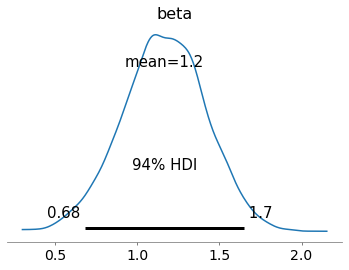

In [19]:
import arviz as az

az.plot_posterior(trace, var_names=['beta'])


## Exercise: Auto-tuning Metropolis-Hastings

Modify the Metropolis-Hastings algorithm below by adding logic to automatically change the proposal scale depending on the acceptance rate of the chain, targeting an acceptance rate of around 30%. Call the new function `metropolis_tuned`.

In [ ]:
import numpy as np

age = np.array([13, 14, 14,12, 9, 15, 10, 14, 9, 14, 13, 12, 9, 10, 15, 11, 
                15, 11, 7, 13, 13, 10, 9, 6, 11, 15, 13, 10, 9, 9, 15, 14, 
                14, 10, 14, 11, 13, 14, 10])
price = np.array([2950, 2300, 3900, 2800, 5000, 2999, 3950, 2995, 4500, 2800, 
                  1990, 3500, 5100, 3900, 2900, 4950, 2000, 3400, 8999, 4000, 
                  2950, 3250, 3950, 4600, 4500, 1600, 3900, 4200, 6500, 3500, 
                  2999, 2600, 3250, 2500, 2400, 3990, 4600, 450,4700])/1000.

rnorm = np.random.normal
runif = np.random.rand

from scipy.stats import gamma, norm
dgamma = gamma.logpdf
dnorm = norm.logpdf

def calc_posterior(a, b, t, y=price, x=age):
    # Calculate joint posterior, given values for a, b and t

    # Priors on a,b
    logp = dnorm(a, 0, 10000) + dnorm(b, 0, 10000)
    # Prior on t
    logp += dgamma(t, 0.001, 0.001)
    # Calculate mu
    mu = a + b*x
    # Data likelihood
    logp += sum(dnorm(y, mu, t**-0.5))
    
    return logp

def metropolis(n_iterations, initial_values, prop_var=1):

    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
    
    # Initialize acceptance counts
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%1000: print('Iteration %i' % i)
    
        # Grab current parameter values
        current_params = trace[i]
    
        for j in range(n_params):
    
            # Get current value for parameter j
            p = trace[i].copy()
    
            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                
    return trace, accepted

In [ ]:
# Write your answer here

def metropolis_tuned(n_iterations, initial_values, prop_var=1, 
                     tune_for=None, tune_interval=100):
     
    n_params = len(initial_values)
             
    # Initial proposal standard deviations
    prop_sd = [prop_var] * n_params
     
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
     
    # Set initial values
    trace[0] = initial_values
    # Initialize acceptance counts
    accepted = [0]*n_params
     
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
     
    if tune_for is None:
        tune_for = n_iterations/2
     
    for i in range(n_iterations):
     
        if not i%1000: print('Iteration %i' % i)
     
        # Grab current parameter values
        current_params = trace[i]
     
        for j in range(n_params):
     
            # Get current value for parameter j
            p = trace[i].copy()
     
            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
             
            # Insert new value 
            p[j] = theta
     
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
     
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
     
            # Sample a uniform random variate
            u = runif()
     
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                 
            # Tune every 100 iterations
            if (not (i+1) % tune_interval) and (i < tune_for):
         
                # Calculate aceptance rate
                acceptance_rate = (1.*accepted[j])/tune_interval
                if acceptance_rate<0.2:
                    prop_sd[j] *= 0.9
                elif acceptance_rate>0.5:
                    prop_sd[j] *= 1.1
                accepted[j] = 0
                 
    return trace[tune_for:], accepted